### ⚠ IMPORTANT ⚠

You will need at least 15GB of VRAM (GPU RAM) to run this notebook.

If you're running this locally - please ensure you have the correct hardware to support the fine-tuning.

# Task Fine-tuning a GPT-style model using `peft`, `transformers` and `bitsandbytes`

In the following notebook, we'll task fine-tune a GPT-style model on the summarization task using:

- [QLoRA](https://arxiv.org/pdf/2305.14314.pdf)/[LoRA](https://arxiv.org/pdf/2106.09685.pdf)

The basic idea is that we will fine-tune an "adapter" which will represent a small subset of trainable weights on our task. This will allow us to instruct-tune a comparitively large model with consumer level resources.

The model we'll be instruct-tuning today is [`NousResearch/Meta-Llama-3-8B-Instruct`](https://huggingface.co/NousResearch/Meta-Llama-3-8B-Instruct)!

> NOTE: The official Llama 3 weights are gated behind a EULA - while using the NousResearch version does not change the acceptable use of the model, it does shortcut needing to wait for the EULA to be accepted.

### Homework Sections

The notebook will be broken into the following sections:

1. Breakout Room #1:
  - Task #1: Loading the Model
2. Breakout Room #2:
  - Task #2: Data and Data Prep.
  - Task #3: Setting up PEFT LoRA
  - Task #4: Training the Model
  - Task #5: Share Your Model!

There are a total of 6 Questions, and 1 Activity, all of which must be completed to receive full marks for the homework.


#### ❓Question #1:

What makes Llama 3 8B Instruct a good model to use for a summarization task?

**ANSWER**

It's a large model (8B parameters) and is good at following instructions. 

### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

# 🤝 Breakout Room #1

### Setting Up Dependencies

We'll start by setting up the dependencies!

In [3]:
!pip install -qU bitsandbytes datasets accelerate loralib peft transformers trl

We'll first verify we're in a GPU instance.

In [4]:
import torch
torch.cuda.is_available()

True

Time to import some dependencies!

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 40GB GPU.
- `bnb_4bit_quant_type` - setting this to the desired format of `nf4` will ensure we're using the most memory efficient datatype for 4bit storage.
- `bnb_double_quant` - setting this to true will save us memory by quantizing the quantization config
- `bnb_4bit_compute_dtype` - since we will not use a 4-bit representation to compute, we need to provide a desired format for our compute type so our weights can be upcast to something while we flow information through our network.



In [6]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

#### ❓Question #2:

What exactly is happening in the double quantization step?

> NOTE: You can use the paper provided to find the answer!

**ANSWER**

I reviewed the paper and here's the key section.  Basically, you're performing a second quantization of the first quantizatin parameters to reduce memory requirements.

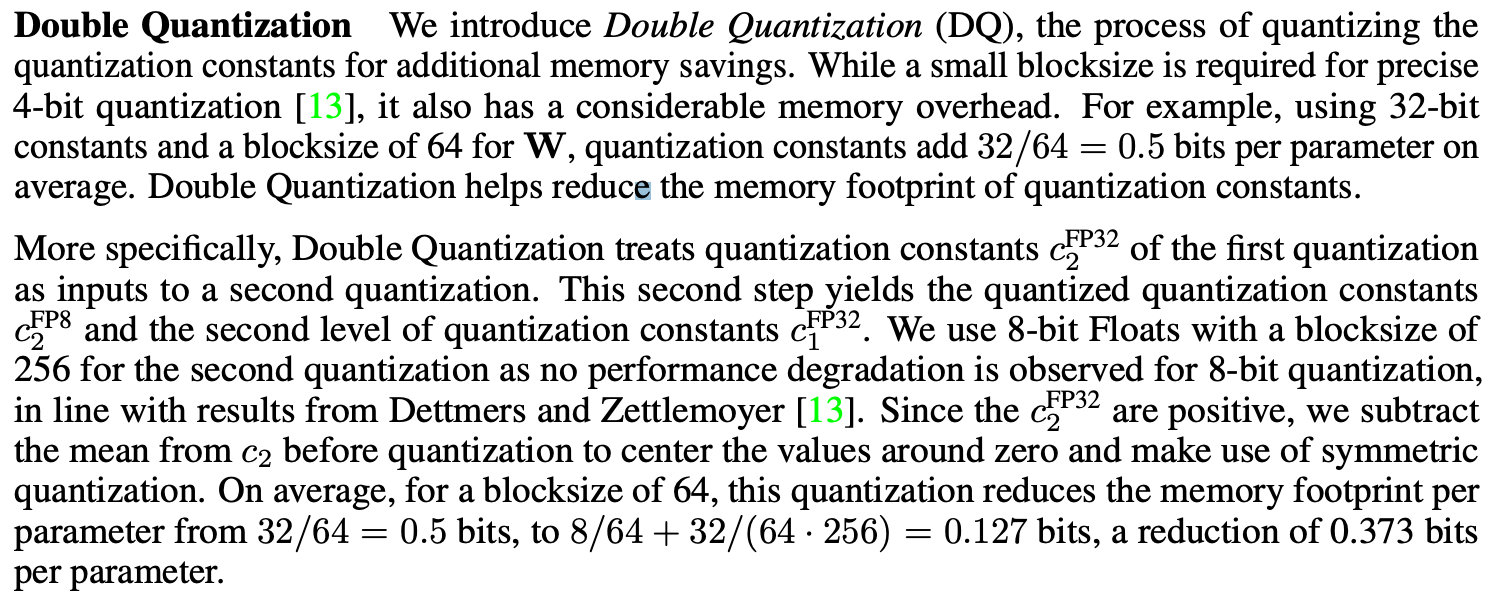

Now we can load the model.

In [7]:
model_id = "NousResearch/Meta-Llama-3.1-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [9]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

### Model Architecture

It's important to observe the model's construction!

This one should look familiar!

In [10]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [11]:
model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false

#### ❓Question #3:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `NousResearch/Meta-Llama-3-8B-Instruct`'s architecture.

- EXAMPLE - Layer Norm:
  - `(input_layernorm): LlamaRMSNorm()`
  - `(post_attention_layernorm): LlamaRMSNorm()`
  - `(norm): LlamaRMSNorm()`

**ANSWER**
- Feed Forward:  The feed-forward component in this model structure is the LlamaMLP module within each LlamaDecoderLayer.
- Masked Multi Self-Attention:  The LlamaSdpaAttention module is the one responsible for Masked Multi Self-Attention in this model structure.
- Text & Position Embed:  The "Text & Position Embed" portion of the model is handled by two components:  embed_tokens and rotary_emb
- Text Prediction: The lm_head layer is responsible for text prediction in the LlamaForCausalLM model.

# 🤝 Breakout Room #2

## Task #2: Data and Data Preparation

Since we'll be focusing on summarization fine-tuning - we'll need to find a summarization dataset!

There are a few good examples available to use on the Hugging Face [dataset](https://huggingface.co/datasets?task_categories=task_categories:summarization&sort=trending) hub - let's check a few of them out!

> NOTE: The link above is pre-filtered to include datasets with the summarization tag

### Summarization Datasets

Let's see what is available for us:

- [`databricks/databricks-dolly-15k`](https://huggingface.co/datasets/databricks/databricks-dolly-15k)
  - this dataset is comprised of ~15K rows of various tasks of which ~7% is summarization data
- [`samsum`](https://huggingface.co/datasets/samsum)
  - this dataset contains ~16K conversations in messenger format as well as their summaries
- [`CohereForAI/aya_collection`](https://huggingface.co/datasets/CohereForAI/aya_collection)
  - similar to Dolly-15K, this dataset contains a wide range of *multilingual* tasks - a subset of which is summarization
- [`Plain English Summary of Contracts`](https://github.com/lauramanor/legal_summarization)
  - contains legal document (EULA, TOS, etc) and natural language summary pairs.

Today we'll be using the Plain English Summary of Contracts dataset to fine-tune Llama 3 8B Instruct to provide natural language descriptions of Legal Documents!

The first step will be to download the dataset from GitHub!

In [12]:
!git clone https://github.com/lauramanor/legal_summarization

Cloning into 'legal_summarization'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 31 (delta 2), reused 0 (delta 0), pack-reused 25 (from 1)
Receiving objects: 100% (31/31), 136.60 KiB | 19.51 MiB/s, done.
Resolving deltas: 100% (10/10), done.


Then we can load it into a list of JSON objects.

In [13]:
import json

jsonl_array = []

with open('legal_summarization/tldrlegal_v1.json') as f:
  data = json.load(f)
  for key, value in data.items():
    jsonl_array.append(value)

Finally we can convert our list of JSON objects to a dataset quickly and effectively using the Hugging Face [`datasets`](https://huggingface.co/docs/datasets/en/index) library!

In [14]:
from datasets import Dataset, load_dataset

legal_dataset = Dataset.from_list(jsonl_array)

Let's check how many items we have in each of our training, validation, and test subsets.

In [15]:
legal_dataset

Dataset({
    features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
    num_rows: 85
})

We can now format our dataset into a training test split!

In [16]:
legal_dataset = legal_dataset.train_test_split(test_size=0.2)

In [17]:
legal_dataset_test_valid = legal_dataset["test"].train_test_split(test_size=0.5)

In [18]:
from datasets import DatasetDict

legal_dataset = DatasetDict({
    "train" : legal_dataset["train"],
    "test" : legal_dataset_test_valid["test"],
    "validation" : legal_dataset_test_valid["train"]
})

In [19]:
legal_dataset

DatasetDict({
    train: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 68
    })
    test: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 8
    })
})

Let's look at a single example to see the format we're working with!

In [20]:
legal_dataset["train"][0]

{'doc': 'Facebook Terms of Service (Statement of Rights and Responsibilities)',
 'id': '53cfb1e809cc3f9e24000101',
 'original_text': 'if you are a developer or operator of a platform application or website the following additional terms apply to you you are responsible for your application and its content and all uses you make of platform. this includes ensuring your application or use of platform meets our facebook platform policies and our advertising guidelines. your access to and use of data you receive from facebook will be limited as follows you will only request data you need to operate your application. you will have a privacy policy that tells users what user data you are going to use and how you will use display share or transfer that data and you will include your privacy policy url in the developer application. you will not use display share or transfer a user s data in a manner inconsistent with your privacy policy. you will delete all data you receive from us concerning a

### Instruction Templating

Instruction-tuned LLMs will typically use a specific template when being trained to accomodate various instruction sets, as well as for better chat and multi-turn use-cases.

Here is the format as indicated in Meta's [llama3](https://github.com/meta-llama/llama3?tab=readme-ov-file#instruction-tuned-models) repository, as well as the intuition behind the prompt template.

> The fine-tuned models were trained for dialogue applications. To get the expected features and performance for them, a specific formatting defined in ChatFormat needs to be followed: The prompt begins with a `<|begin_of_text|>` special token, after which one or more messages follow. Each message starts with the `<|start_header_id|>` tag, the role `system`, `user` or `assistant`, and the `<|end_header_id|>` tag. After a double newline `"\n\n"` the contents of the message follow. The end of each message is marked by the `<|eot_id|>` token.

Here is an example of this format:

```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]
welcome to the pokémon go video game services which are accessible via the niantic inc niantic mobile device application the app. to make these pokémon go terms of service the terms easier to read our video game services the app and our websites located at http pokemongo nianticlabs com and http www pokemongolive com the site are collectively called the services. please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.
[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>

hi.<|eot_id|>
```

> NOTE: We're adding our own special tokens here in `[LEGAL_DOC]` and `[END_LEGAL_DOC]` to encourage the model to better understand our context, but these are not special tokens that are already understood by the model.

#### 🏗️ Activity #1: Creating the `create_prompt` function

We'll create a function that will take a row of our dataset, along with a default False flag that creates the prompt in the format expressed above.

In [21]:
INSTRUCTION_PROMPT_TEMPLATE = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a short human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]{LEGAL_TEXT}[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

RESPONSE_TEMPLATE = """\
{NATURAL_LANGUAGE_SUMMARY}<|eot_id|><|end_of_text|>"""

In [22]:
def create_prompt(sample, include_response = True):
  """
  Parameters:
    - sample: dict representing row of dataset
    - include_response: bool

  Functionality:
    This function should build the Python str `full_prompt`.

    If `include_response` is true, it should include the summary -
    else it should not contain the summary (useful for prompting) and testing

  Returns:
    - full_prompt: str
  """
  full_prompt = INSTRUCTION_PROMPT_TEMPLATE.format(LEGAL_TEXT=sample["original_text"])

  if include_response:
    full_prompt += RESPONSE_TEMPLATE.format(NATURAL_LANGUAGE_SUMMARY=sample["reference_summary"])


  return full_prompt

In [23]:
print(create_prompt(legal_dataset["test"][1]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a short human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]termination. if we want we can terminate this eula if you breach the terms. you can terminate it too at any time all you have to do is uninstall the game from your computer and the eula will be terminated. if the eula is terminated you will no longer be allowed to play our game. the paragraphs about ownership of our game our liability and general stuff will continue to apply even after the eula is terminated.[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>you can terminate the eula by uninstalling the game.<|eot_id|><|end_of_text|>


In [24]:
def generate_response(prompt, model, tokenizer):
  """
  Parameters:
    - prompt: str representing formatted prompt
    - model: model object
    - tokenizer: tokenizer object

  Functionality:
    This will allow our model to generate a response to a prompt!

  Returns:
    - str response of the model
  """

  # convert str input into tokenized input
  encoded_input = tokenizer(prompt,  return_tensors="pt")

  # send the tokenized inputs to our GPU
  model_inputs = encoded_input.to('cuda')

  # generate response and set desired generation parameters
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=256,
      do_sample=True,
      pad_token_id=tokenizer.eos_token_id
  )

  # decode output from tokenized output to str output
  decoded_output = tokenizer.batch_decode(generated_ids)

  # return only the generated response (not the prompt) as output
  return decoded_output[0].split("<|end_header_id|>")[-1]

In [25]:
generate_response(create_prompt(legal_dataset["test"][1], include_response=False),
                  model,
                  tokenizer)

"\n\nHere's a short, human-readable summary:\n\n**Termination of Agreement**\n\nEither we or you can end this agreement at any time. To terminate, you just need to uninstall the game from your computer. If the agreement is ended, you won't be able to play the game anymore. However, some rules will still apply, such as our ownership of the game and our liability.<|eot_id|>"

In [26]:
# Ground Truth Summary
legal_dataset["test"][1]["reference_summary"]

'you can terminate the eula by uninstalling the game.'

Let's try another just to see how the model responds to a different prompt.

In [27]:
generate_response(create_prompt(legal_dataset["test"][3], include_response=False),
                  model,
                  tokenizer)

"\n\nHere is a short, human-readable summary:\n\nYou can use data from our APIs to show targeted ads in your app, as long as you're selling the ad space directly to the advertiser and not acting as an ad network. Additionally, you can share anonymized user data with a third party to help them serve ads to your app.<|eot_id|>"

In [28]:
# Ground Truth Summary
legal_dataset["test"][3]["reference_summary"]

'if you re not an ad network and you sell ads direct to clients you can use the data to target ads.'

The response, while an accurate *recounting* of the conversation is certainly not what would be consider to be a summary.

Let's see how fine-tuning can improve these responses.

### Required Post Processing

Finally, we need to apply some post-processing on the 4-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

Instead of doing this manually, of course, we can use the helper function `prepare_model_for_kbit_training`! You can look at the source code [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/utils/other.py#L67)

In [29]:
from peft import prepare_model_for_kbit_training
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)

## Task #3: Setting up PEFT LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

#### Helper Function to Print Parameter %age

This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [30]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

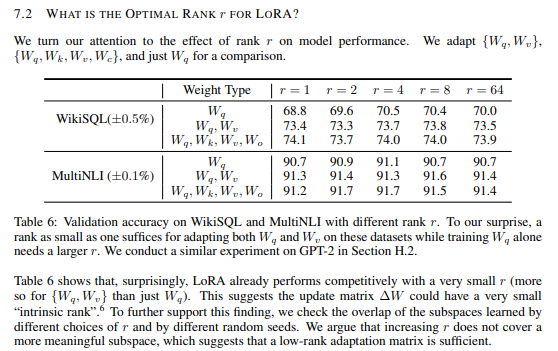


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

In [31]:
from peft import LoraConfig, get_peft_model

# set our rank (higher value is more memory/better performance)
lora_r = 16

# set our dropout (default value)
lora_dropout = 0.1

# rule of thumb: alpha should be (lora_r * 2)
lora_alpha = 32

# construct our LoraConfig with the above hyperparameters
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM"
)

Now that we have our PEFT config - we need to convert our model into a PEFT model!

We can use the convenient helper function `get_peft_model` to do so.

Documentation found [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/mapping.py#L98)!

In [32]:
model = get_peft_model(
    model,
    peft_config
)

print_trainable_parameters(model)

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


In [33]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): 

#### ❓Question #4:

What modules (or groupings of layers) did we apply LoRA too - and how can we tell from the model summary?

**ANSWER**

LoRA (Low-Rank Adaptation) is applied to the linear layers within the LlamaForCausalLM model.  In the original model, the linear layers are directly defined using Linear4bit. In the model with LoRA applied, the Linear4bit layers are wrapped within the lora.Linear4bit class. This class adds additional parameters, namely lora_A, lora_B, lora_embedding_A, and lora_embedding_B. These additional parameters are low-rank matrices that are trained along with the original model. They are used to adjust the weights of the original linear layers, allowing the model to adapt to new tasks or datasets without requiring full fine-tuning. In summary, LoRA is applied to the linear layers within the model, adding low-rank parameters that can be trained to fine-tune the model without training all of its parameters.

## Task #4: Training the Model

Now we'll be training our model with the created dataset!



### Setting up Training

The `SFTConfig` class contains all the usual suspects - these are the same hyper-parameters you know and love from from previous notebooks!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [34]:
from trl import SFTConfig

max_seq_length = 1024

args = SFTConfig(
  output_dir = "llama381binstruct_summarize_short",
  #num_train_epochs=5,
  max_steps = 500, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 1,
  warmup_steps = 30,
  logging_steps=10,
  #evaluation_strategy="epoch",
  eval_strategy="steps",
  eval_steps=25, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2e-4,
  lr_scheduler_type='linear',
  dataset_kwargs={
        "add_special_tokens" : False,
        "append_concat_token" : False,
  },
  max_seq_length=max_seq_length,
  packing=True,
)

#### ❓Question #5:

Describe what the following parameters are doing:

- `warmup_steps`
- `learning_rate`
- `lr_scheduler_type`

> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

**ANSWER**

warmup_steps - Purpose: This parameter controls the initial learning rate schedule. During the warmup phase, the learning rate gradually increases from a small initial value to its maximum value.
Effect: Warmups help to stabilize training and prevent the model from diverging early on. It's especially useful when using large batch sizes or high learning rates.

learning_rate - Purpose: This parameter sets the maximum learning rate used during training. The learning rate determines how quickly the model's parameters are updated based on the gradient of the loss function.
Effect: A higher learning rate can lead to faster convergence but also increases the risk of overshooting the optimal solution. A lower learning rate can be more stable but may take longer to converge.

lr_scheduler_type - Purpose: This parameter specifies the type of learning rate scheduler to use. A learning rate scheduler adjusts the learning rate during training to improve convergence and prevent overfitting.
Effect: In this case, lr_scheduler_type='linear' indicates that a linear learning rate scheduler will be used. This means that the learning rate will decrease linearly from its maximum value to zero over the course of training. This is a common choice for fine-tuning language models.

In [35]:
from trl import SFTTrainer

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  tokenizer=tokenizer,
  formatting_func=create_prompt,
  args=args,
  train_dataset=legal_dataset["train"],
  eval_dataset=legal_dataset["validation"]
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:520: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:431: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


> NOTE: The following cell should take ~45min. or so to complete on a T4 GPU with the pre-set hyper-parameters.

In [36]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.717300,1.622749
50,0.809900,1.592591
75,0.357200,1.729033
100,0.190700,1.826929
125,0.101000,2.060774
150,0.038300,2.259188
175,0.026800,2.175668
200,0.020200,2.176837
225,0.015900,2.259314
250,0.006300,2.280118


TrainOutput(global_step=500, training_loss=0.1934609283991158, metrics={'train_runtime': 2596.6995, 'train_samples_per_second': 0.193, 'train_steps_per_second': 0.193, 'total_flos': 2.3183977611264e+16, 'train_loss': 0.1934609283991158, 'epoch': 25.0})

## Task #5: Share Your Model!

Normally, we would only seek to push the LoRA adapters to the hub. This is a lightweight and memory efficient way to push this model - as you can pull the base model down as part of the inference pipeline.

However, if you want to leverage the one-click-deploy features of Hugging Face, you'll need to first `merge_and_unload()` the model and push the resulting model to the hub. This process will merge the LoRA weights back into the base model.

> NOTE: If you run into issues during upload - please ensure you're using a HF Token with `WRITE` access!

In [39]:
from huggingface_hub import notebook_login

notebook_login()

In [40]:
trainer.push_to_hub("ai-maker-space/llama381binstruct_summarize_short")

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

events.out.tfevents.1726439215.55b15e9d92b9.199.0:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.50k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/dstampfli/llama381binstruct_summarize_short/commit/c3f46288f923da6f38280a4086e5a1209b17f49a', commit_message='ai-maker-space/llama381binstruct_summarize_short', commit_description='', oid='c3f46288f923da6f38280a4086e5a1209b17f49a', pr_url=None, pr_revision=None, pr_num=None)

### Compare Outputs

Let's see how our model fairs at this task, now!

In [41]:
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


#### ❓Question #6:

What does the `merge_and_unload()` method do?

> NOTE: Check out the [documentation](https://huggingface.co/docs/trl/v0.7.11/use_model) or the [source code](https://github.com/huggingface/peft/blob/096fe537370cf8a2cb55cc9bd05c7812ca919405/src/peft/tuners/lora/model.py#L685) to find out!

**ANSWER**

In the provided code snippet, the model.merge_and_unload() method is used to:

Merge adapters: It combines the trained adapters (if any) into the base model's weights. This creates a single, unified model.
Unload adapters: After merging, it removes the original adapter modules from the model's memory. This frees up memory space, especially when using multiple adapters.
By merging adapters, you can use the model as a standard Transformers model without the need to manage separate adapter modules. However, this can significantly increase the model's size.

In [42]:
generate_response(create_prompt(legal_dataset["test"][1], include_response=False),
                  merged_model,
                  tokenizer)

"\n\nHere is a short human-readable summary:\n\n**Terminating the Agreement**\n\nEither we or you can end this agreement (EULA) if you break its rules. To end it, you simply need to uninstall the game from your computer. If the agreement is ended, you won't be able to play the game anymore. However, some rules, such as who owns the game and our liability, will still apply.<|eot_id|>"

Let's look at the base model response:

> **Using YouTube Content**\n\nYou can access YouTube content for personal, non-commercial use through the website or app. You can only download content if a "download" link is provided by YouTube. You need permission from YouTube or the content owner to:\n\n* Copy, reproduce, distribute, transmit, broadcast, display, sell, or license content for any other purpose.\n* Use content for any purpose other than personal, non-commercial use.\n\nYouTube and its owners retain all rights not explicitly granted in the terms of service.

Now the fine-tuned response:

> **Using YouTube Content**\n\n* You can access and use YouTube content for personal use and as intended by the service.\n* You can only download content if a download link is explicitly provided by YouTube.\n* You need permission from YouTube or the content owner to use, copy, reproduce, distribute, or sell content for any purpose other than personal use.



We can see that, directionally, our model is getting much closer to our desired results with only *100* steps of training.

Let's try another example to make sure it wasn't a fluke!

In [43]:
legal_dataset["test"][3]["original_text"]

'notwithstanding the foregoing or section b 1 of the google platform developer policies and provided that you don t operate as an ad network you may use user data from our apis to target ads within your api client where you have sold the ad slot to the advertiser directly directly sold ads and you may make anonymized user data from our apis available to a third party solely to enable that third party to serve directly sold ads to your api client.'

In [44]:
generate_response(create_prompt(legal_dataset["test"][3], include_response=False),
                  merged_model,
                  tokenizer)

"\n\nHere is a short human-readable summary:\n\nYou can use user data from Google's APIs to target ads within your app or website, as long as you're not operating as an ad network. If you sell ad space directly to an advertiser, you can also share anonymized user data with a third-party company to help them serve ads to your app or website.<|eot_id|>"

In [45]:
# Ground Truth Summary
legal_dataset["test"][3]["reference_summary"]

'if you re not an ad network and you sell ads direct to clients you can use the data to target ads.'

Lets look at the base model response:

>  **Permission to Use Your Content**\n\nWhen you create content for our game, you grant us permission to:\n\n* Use your content as we see fit\n* Make copies of your content\n* Modify or adapt your content\n* Allow others to use, copy, modify, or adapt your content\n\nIf you don't want to give us this permission, don't create content for our game.

And the fine-tuned model:

> **Permission for Game Content**\n\nWhen you share content on our game, you agree to let us:\n\n* Use, modify, and adapt your content\n* Allow others to use, modify, and adapt your content\n* This permission is permanent and can't be taken back\n* Consider carefully before sharing content, as it will be public and may be used in ways you don't like.

And again, we can see that the model performs the task *better* than the original un-fine-tuned model, in that the language is less formal - though there is still work to do.